# Overview of statistics passing through BatchNorm

In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from visualisation_utils import *

device = 'cpu'

## Loading models and data

download archives from Google Drive and place them in current directory:
  - with test data https://drive.google.com/file/d/1PyD4-_oaHR2zQn2C0LeO0H8B_hR2Sf_p/view?usp=sharing
  - with models https://drive.google.com/file/d/17_lFWdeKVr4qG4tEX0klkgBiu64SFKO8/view?usp=sharing

In [ ]:
!tar -xf data.tar.gz
!tar -xf models.tar.gz
!git clone https://github.com/deepinsight/insightface.git

In [2]:
import sys
sys.path.append('insightface/recognition/arcface_torch')
from backbones import get_model


model_reference_path = 'models/pretrain.pth'
model_tuned_path = 'models/finetuned_model.pth'
model_tuned_100_path = 'models/finetuned_model_100.pth'

model0 = get_model('r100', num_features=512)
model_tuned = get_model('r100', num_features=512)
model_tuned_100 = get_model('r100', num_features=512)

model0.load_state_dict(torch.load(model_reference_path))
model_tuned.load_state_dict(torch.load(model_tuned_path))
model_tuned_100.load_state_dict(torch.load(model_tuned_100_path))

model0 = model0.to(device).eval()
model_tuned = model_tuned.to(device).eval()
model_tuned_100 = model_tuned_100.to(device).eval()

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),])

target_dataset = ImageFolder('data/glint360k', transform=transform)
noised_dataset = ImageFolder('data/imagenet', transform=transform)
target_data, rand_group1, rand_group2, noised_data = torch.load('data/batch.pt')

## Plot BN mean&var

Here we can see how the values of running statistics have changed. To do this, we will build a plot
$\frac{\|a - b\|}{\|b\|}$, where $a$ and $b$ are the corresponding weights of the two models
($a$ - from the tuned model, and $b$ - from the baseline model).

In [ ]:
tuned_models = [model_tuned]
tuned_titles = ["BN-tuned model (with 15% of noise)"]

plot_bn_mean_var(model0, tuned_models, tuned_titles)

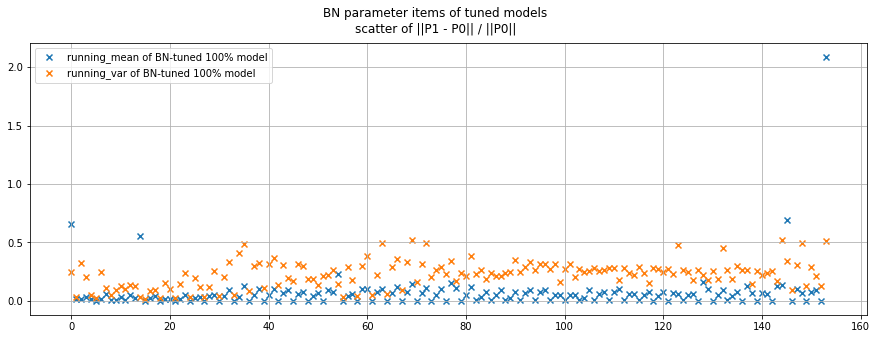

In [8]:
tuned_models = [model_tuned_100]
tuned_titles = ["BN-tuned model (with 100% of noise)"]

plot_bn_mean_var(model0, tuned_models, tuned_titles)

## Plot probability distribution density for batches

Plot description:

1. *batchnorm outputs*

The graph shows the distribution of batch values after it has gone through batch normalization (i.e. after applying
running_mean and running_var, but before applying the weights of the BatchNorm itself). If the BatchNorm is in the
train state, it works like a normalization layer: the input will be normalized using the calculated input stats
(mean and var), i.e. normalized to gaussian normal distribution $\mathcal{N}(0, 1)$. But now (in the eval state)
the values are corrected by the accumulated values. Many graphs show that the distribution tails of the fine-tuned model
are pulled up to the mode of distribution.

2. *batchnorm log_prob* (likelihood BN statistics)

BatchNorm accumulates dataset statistics by approximating them with a normal distribution, so we can calculate NLL
for a batch passing through BN. The larger value means, that this object is less likely for the current BN.

3. *center-distributions for outputs* (relative distances between samples)

Consider the relative position of the samples. Let there be a set of samples that were passed through the batchnorm.
For these samples, we can calculate the centre at L2-normalized space and the cosine distance to this centre.
The distribution of the obtained cosine/euclidean distance is shown in the graphs.

For cosine distance, we consider that independent objects, (i.e. those with zero correlation) will have similarity at
the zero level. Therefore, their distribution must be centred at zero. Which corresponds to the centrality of the
distribution of the global structure of the dataset (in our case, random samples from the dataset). For a model tuned
only by noise, it turns out that the distribution around zero is occupied by the data on which this model was
fine-tuned, i.e. noise. It turns out that the noise is now the training dataset, and the true train dataset is noise.

<h3>(0-4) batchnorm outputs</h3>

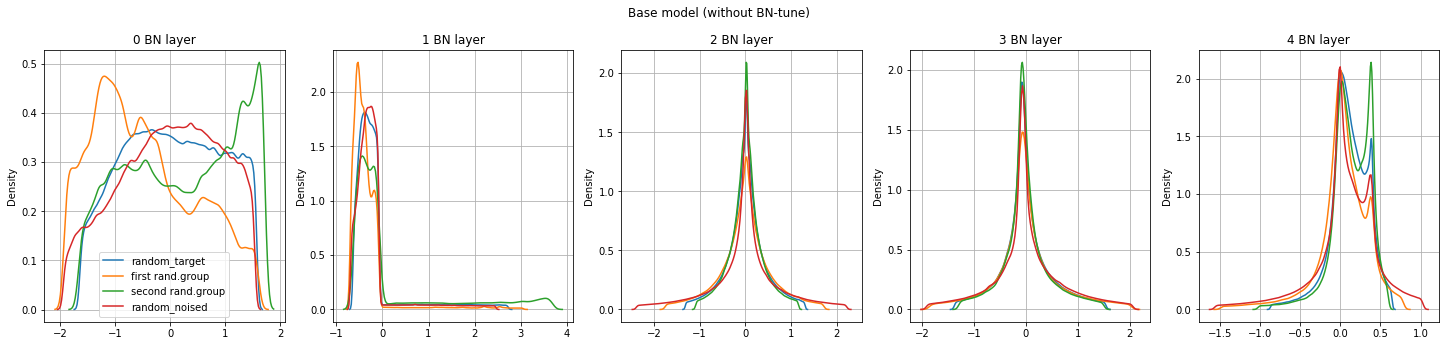

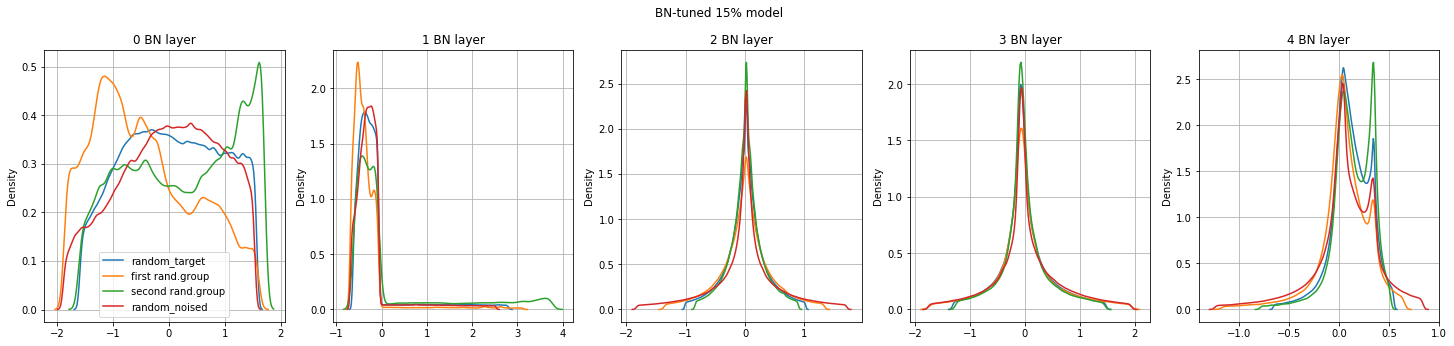

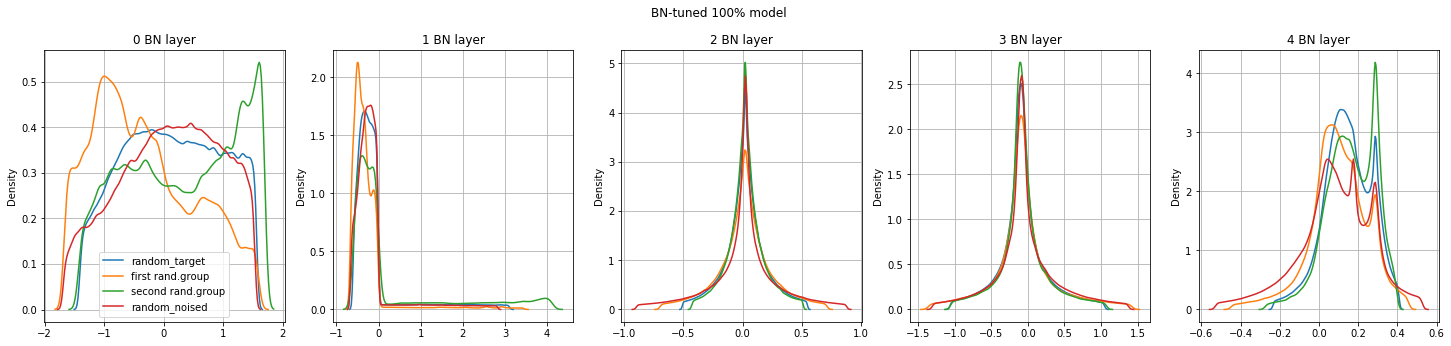

<h3>(149-153) batchnorm outputs</h3>

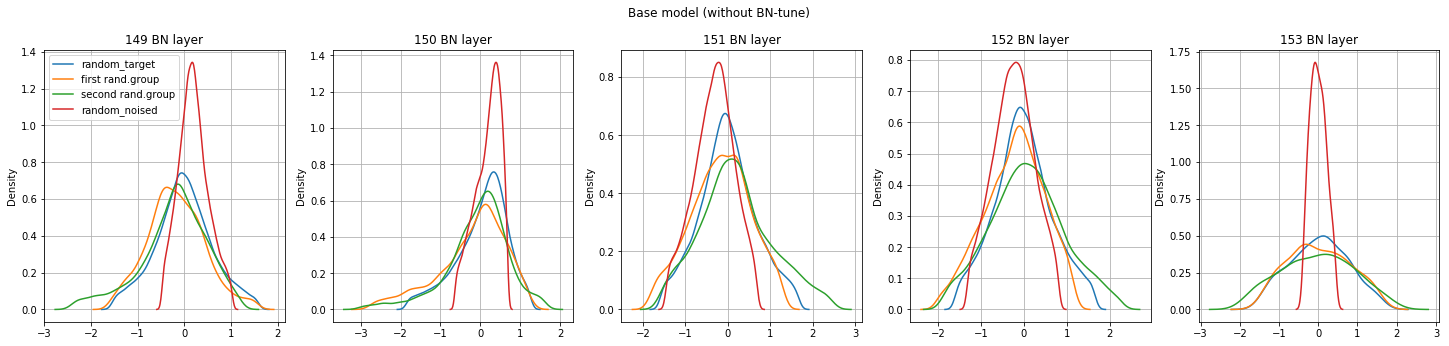

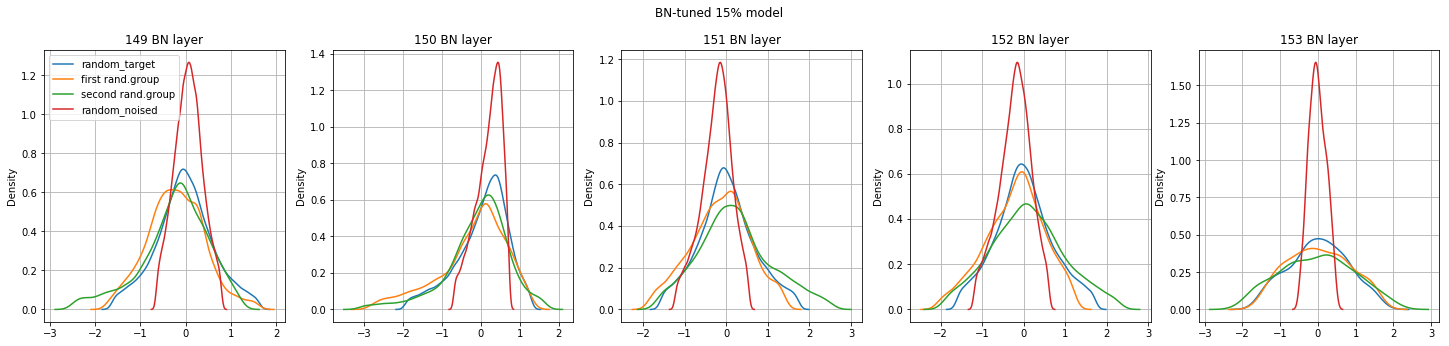

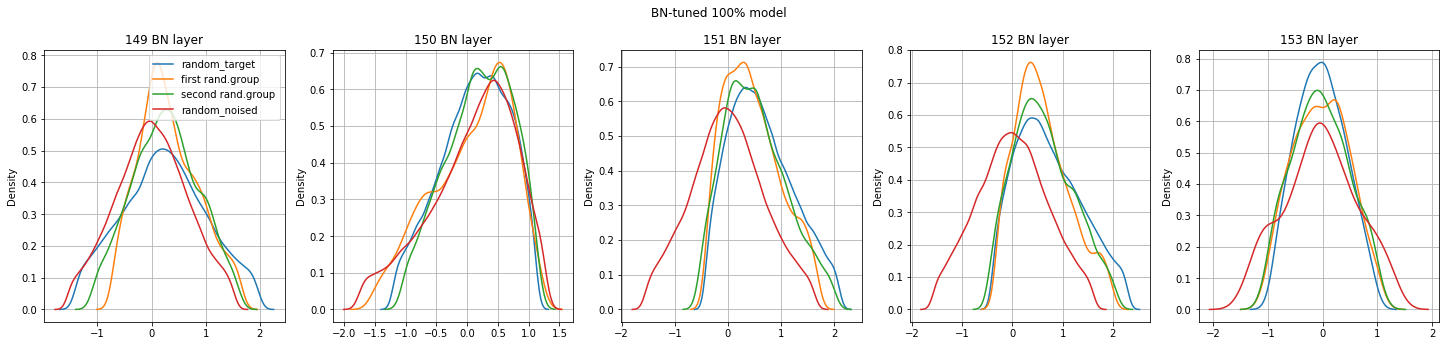

<h3>(0-4) batchnorm log_prob</h3>

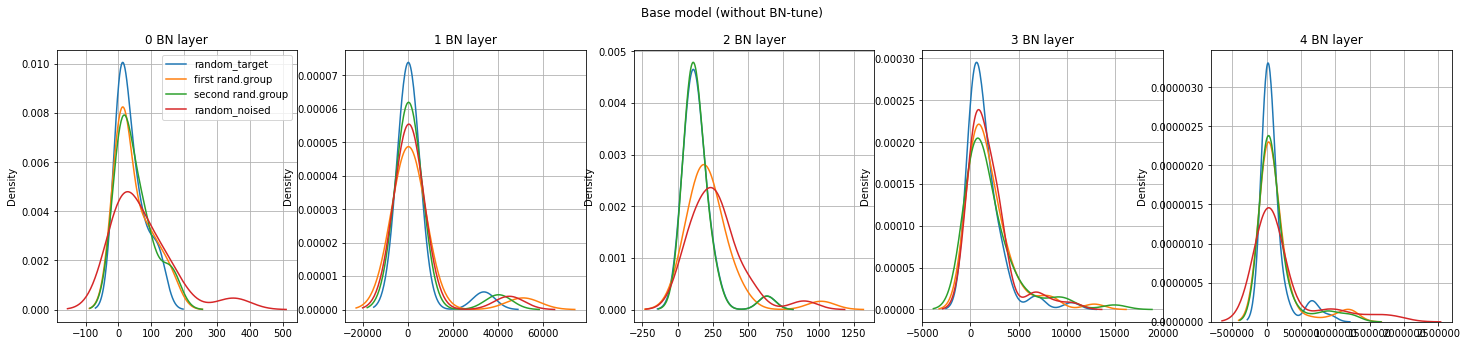

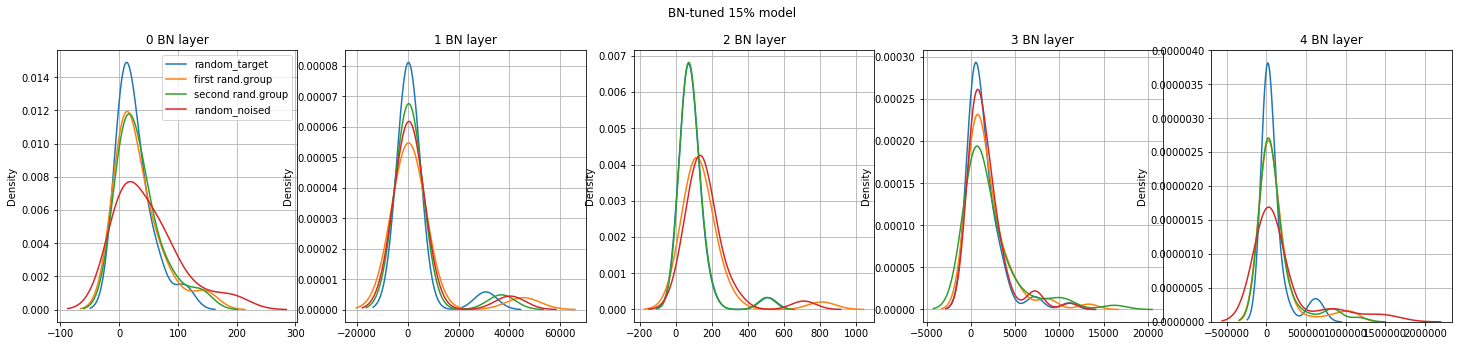

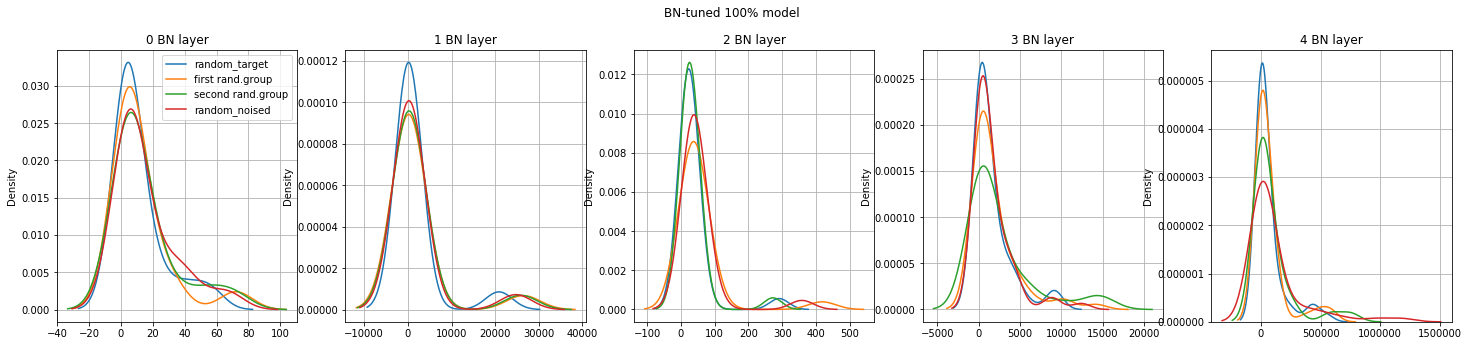

<h3>(149-153) batchnorm log_prob</h3>

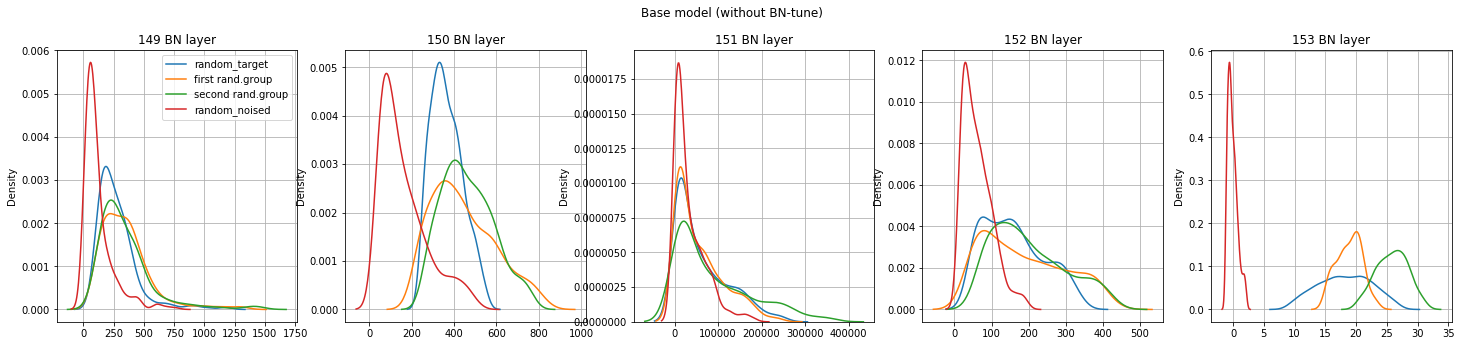

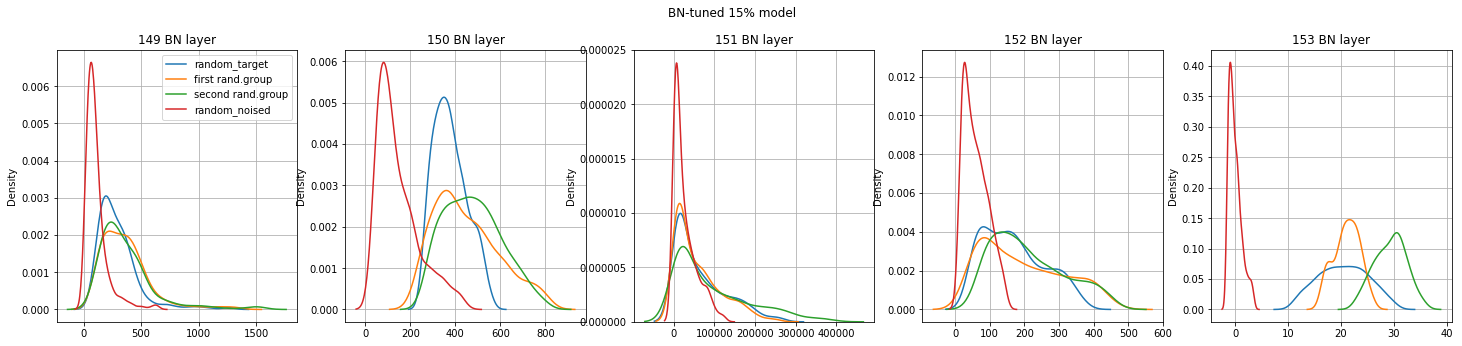

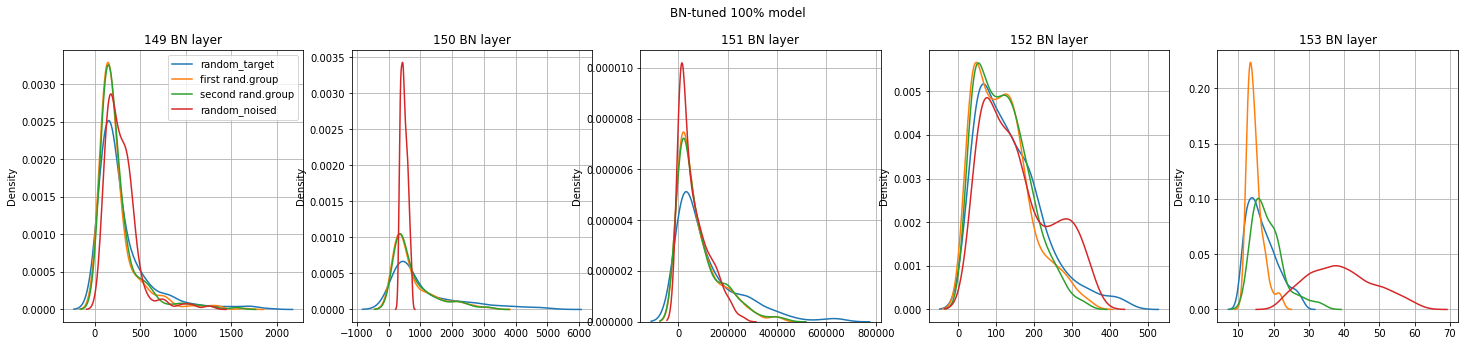

<h3>(149-153) center-distributions for outputs</h3>in cos distance

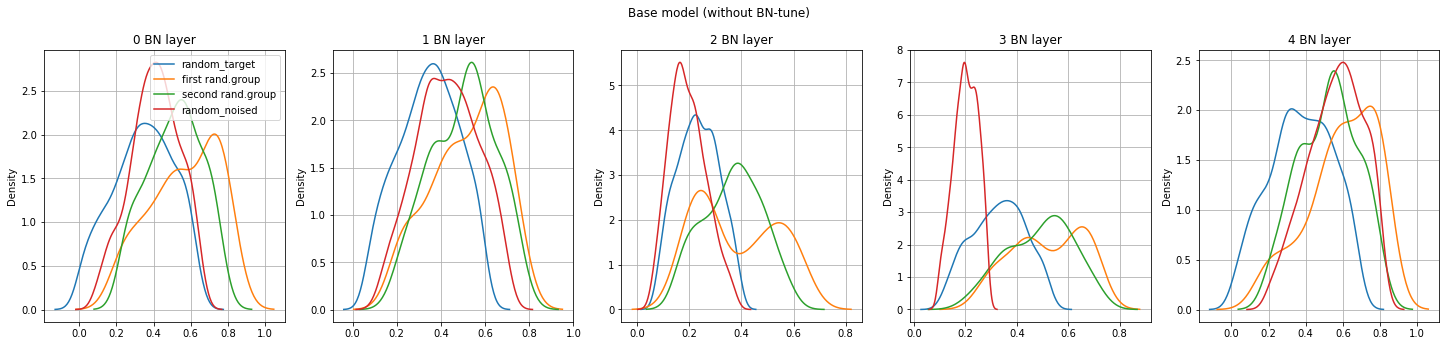

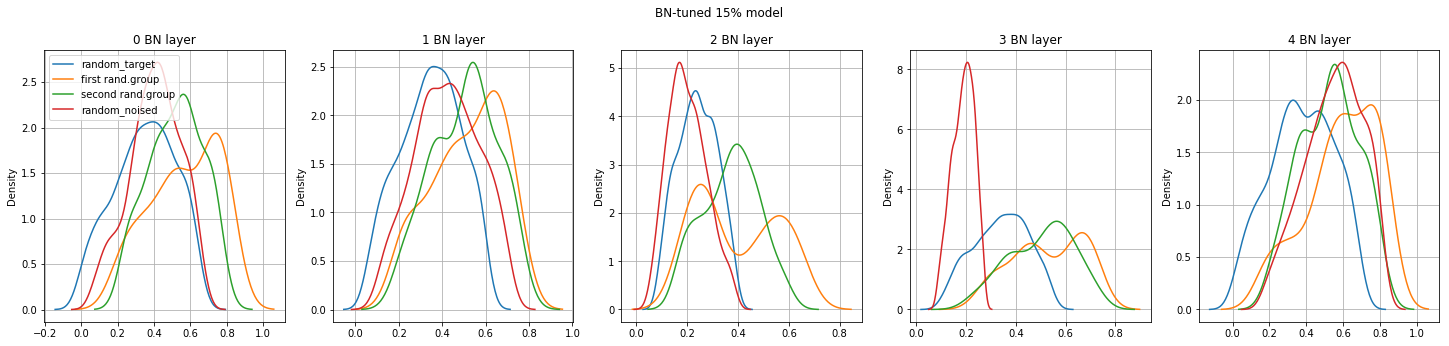

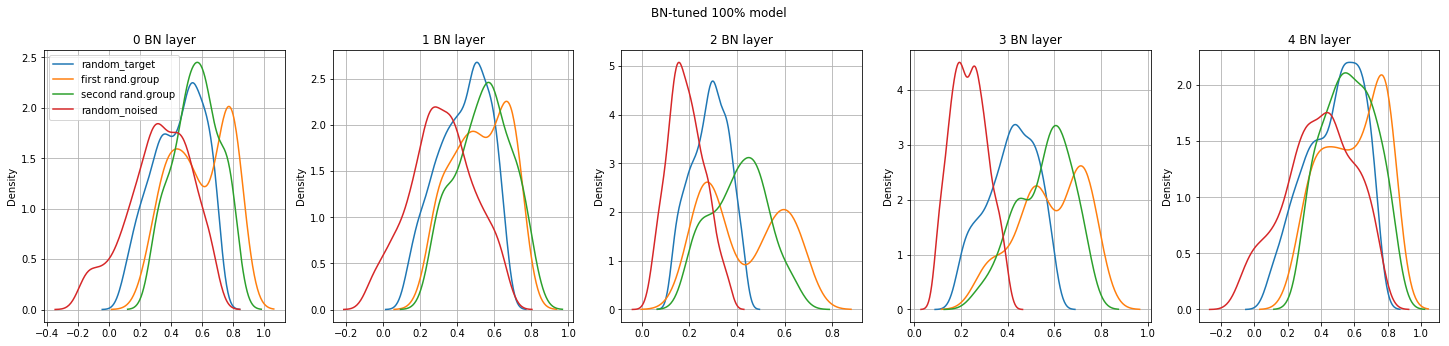

<h3>(149-153) center-distributions for outputs</h3>in cos distance

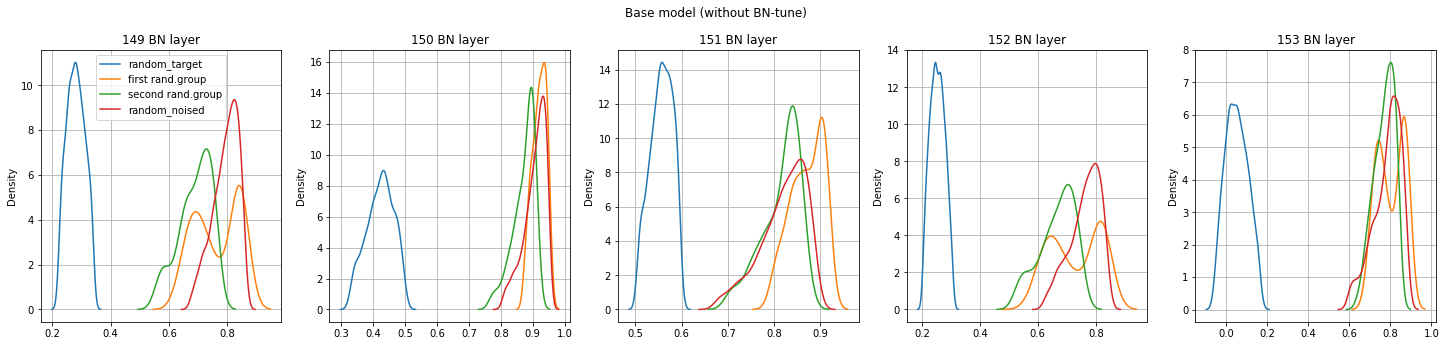

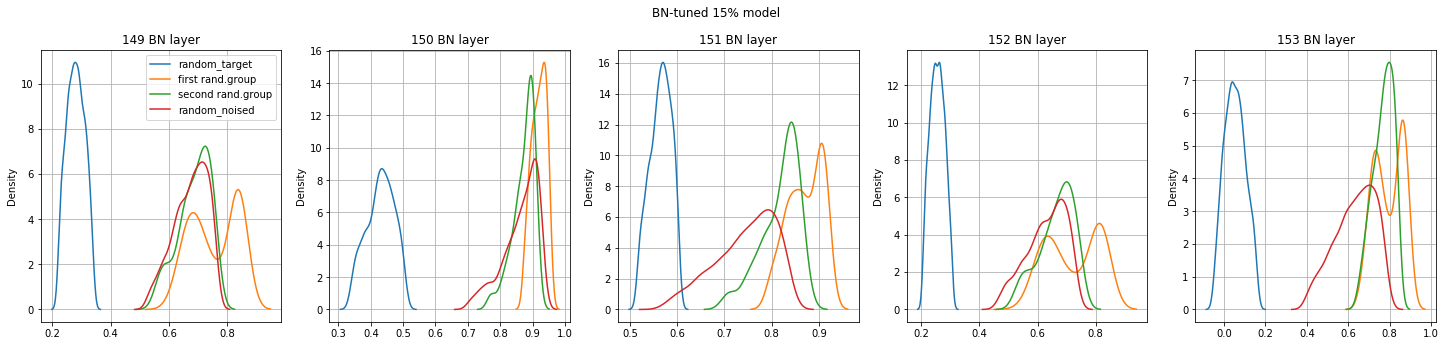

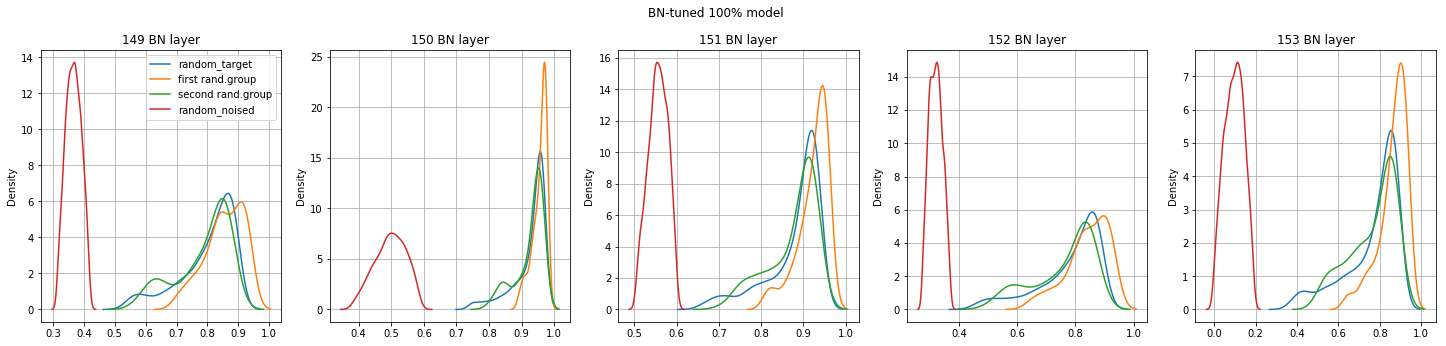

<h3>(149-153) center-distributions for outputs</h3>in euclid distance

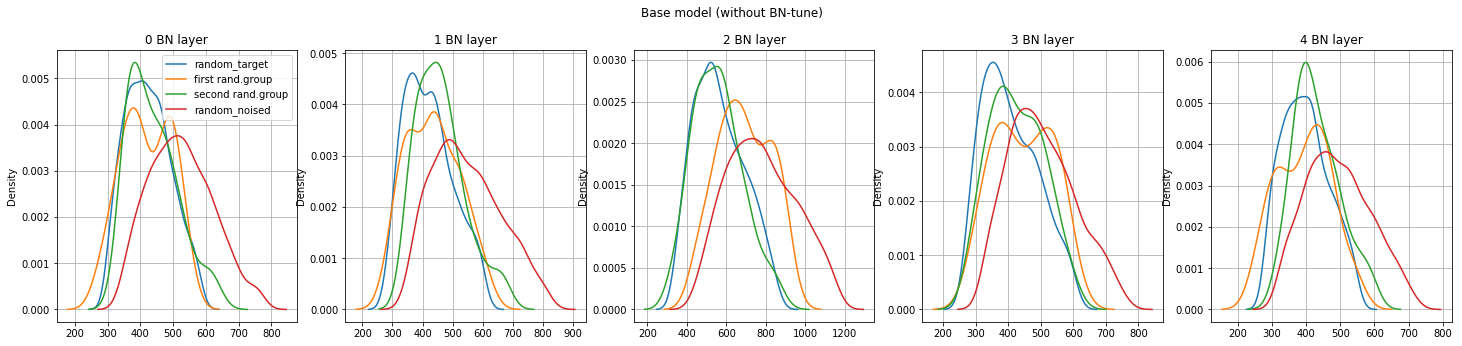

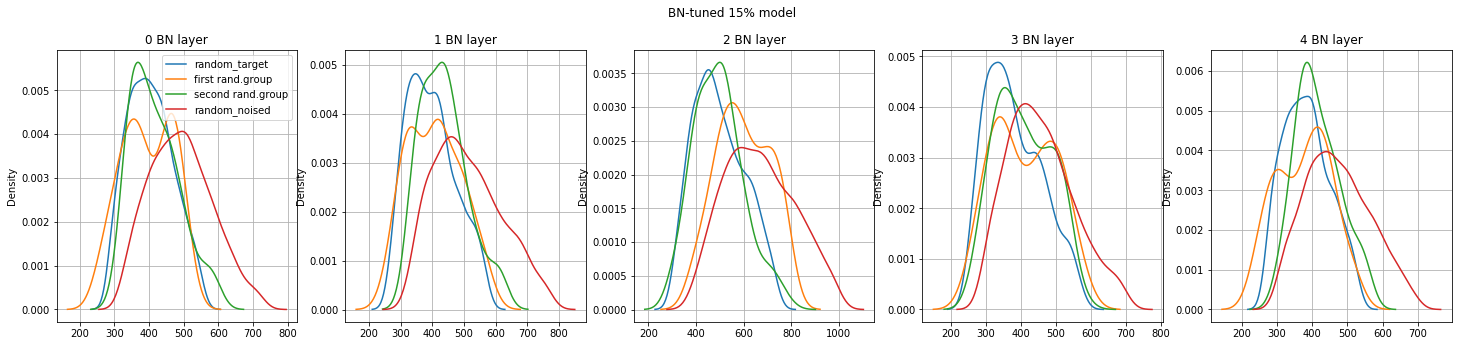

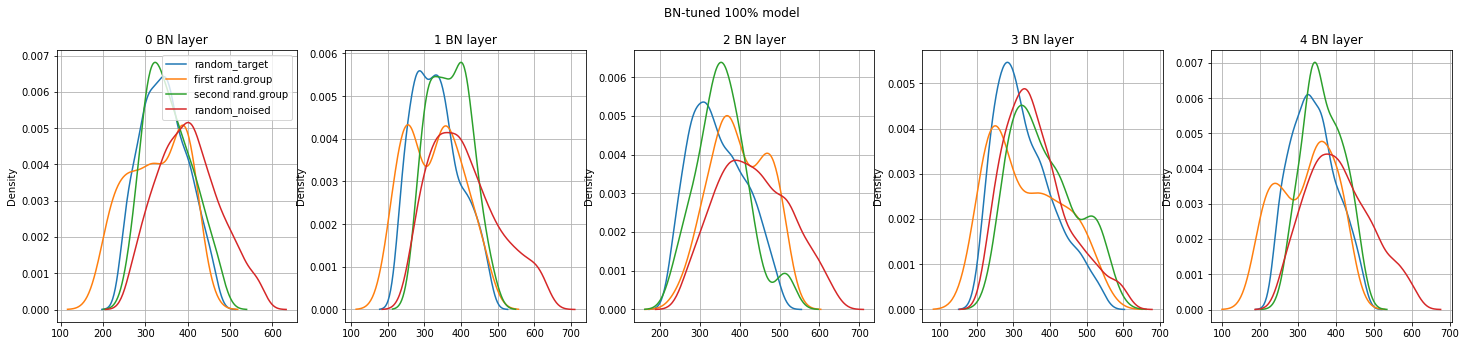

<h3>(149-153) center-distributions for outputs</h3>in euclid distance

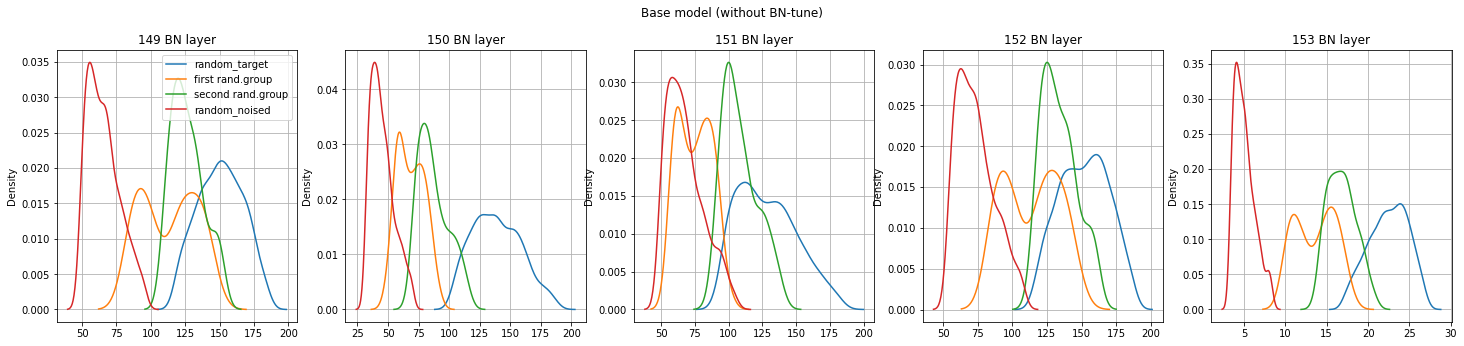

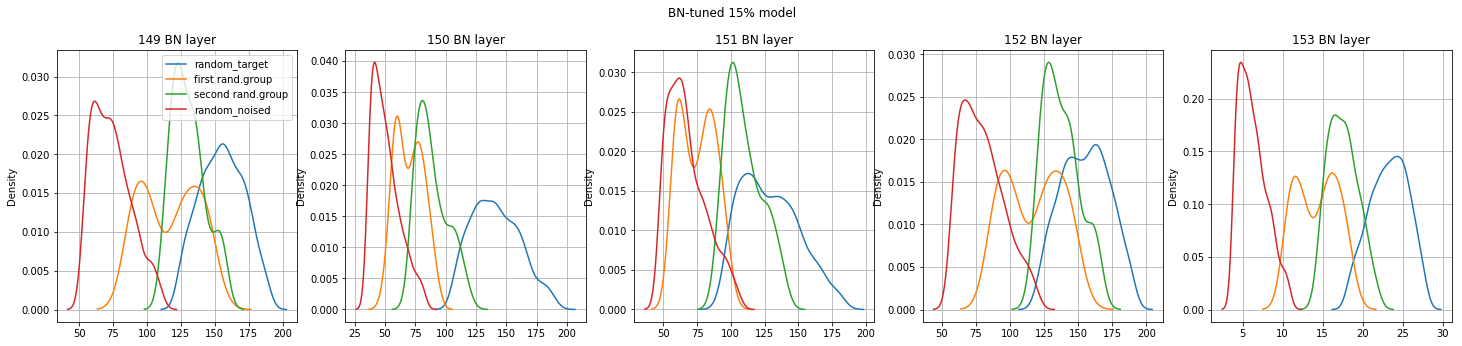

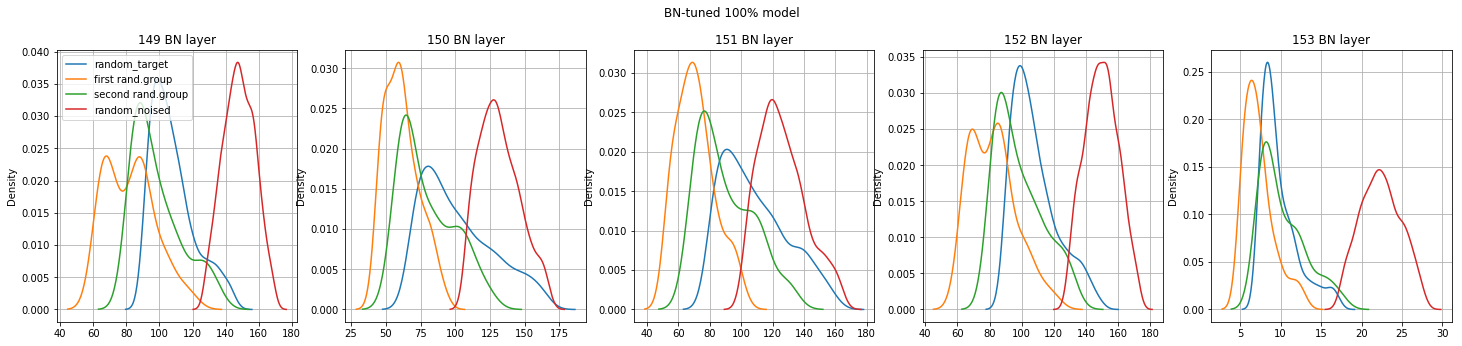

In [4]:
models = [model0, model_tuned, model_tuned_100]
titles = ["Base model (without BN-tune)", "BN-tuned model (with 15% of noise)", "BN-tuned model (with 100% of noise)"]

plot_bn_distributions(target_data, rand_group1, rand_group2, noised_data, models, titles, device=device)

## Likelihood for whole dataset.

Consider the likelihood with respect to the batchnorms of the blurred and clean datasets. We believe that the
dataset on which the model was trained must be centred because batch normalization works in this way. This
means that the random vectors will be orthogonal. Therefore, the blurred ones should be random relative to
each other and, as a result, the distribution of the blurred dataset will be centred. In terms of likelihood,
this means that the modes of distribution of clear and blurred images must match.

<h3>(153) batchnorm</h3>

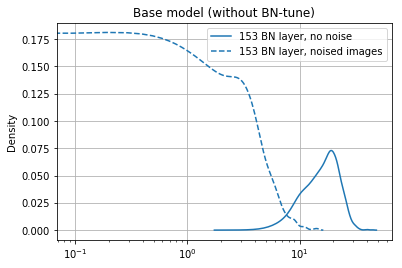

<h3>(153) batchnorm</h3>

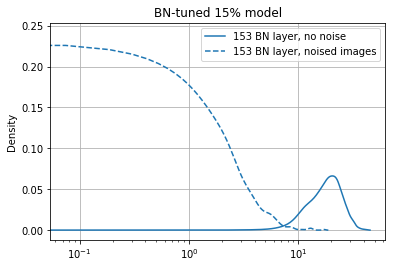

<h3>(153) batchnorm</h3>

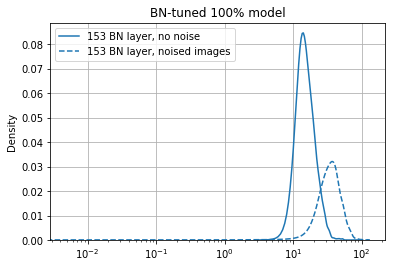

<h3>(152) batchnorm</h3>

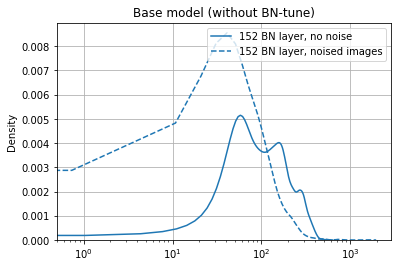

<h3>(152) batchnorm</h3>

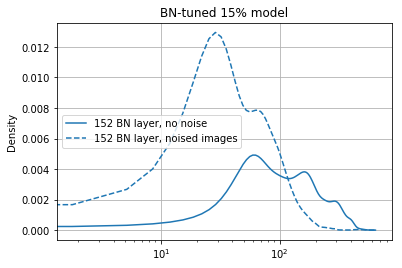

<h3>(152) batchnorm</h3>

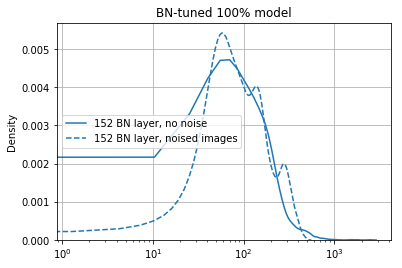

In [6]:
datasets = [target_dataset, noised_dataset]
batch_size = 1000
models = [model0, model_tuned, model_tuned_100]
titles = ["Base model (without BN-tune)", "BN-tuned model (with 15% of noise)", "BN-tuned model (with 100% of noise)"]

plot_ds_bn_prob(datasets, batch_size, models, titles, device=device)